In [1]:
import os
import utils
import model_scoring
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"  # or choose another backend if you wish
import pandas as pd
from bokeh.plotting import figure, output_file, show
from bokeh.models import ColumnDataSource, DatetimeTickFormatter
from bokeh.models.tools import HoverTool
from bokeh.io.export import get_screenshot_as_png
from bokeh.io import output_notebook
import sklearn
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import datetime
import keras
from keras.models import Sequential, Model
from keras.layers import Embedding, Flatten, Dense, Dropout, Input

C:\ProgramData\Miniconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using plaidml.keras.backend backend.


In [2]:
output_notebook()

Loading BokehJS ...

In [3]:
train, test = utils.load_data(hourly=True)

Now, we will normalize the data.

In [4]:
mean = train.mean(axis=0)
std = train.std(axis=0)

utils.preprocess(train, mean, std)
utils.preprocess(test, mean, std)

# I don't think we need to one hot encode our 'Hour' column

In [5]:
labels = train['target'].tolist()
train.drop(columns=['target'], inplace=True)
train.head()

,temp,dwpt,heat_idx,rh,pressure,vis,wc,wdir,wspd,prcp,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
2014-09-25 06:00:00,63.0,57.0,63.0,81.0,30.36,10.0,63.0,50.0,20.0,0.0,...,0,0,0,0,0,0,1,0,0,0
2005-09-23 02:00:00,74.0,63.0,74.0,68.0,29.93,10.0,74.0,240.0,13.0,0.0,...,0,0,0,0,0,0,1,0,0,0
2006-07-31 02:00:00,79.0,66.0,81.0,64.0,29.83,10.0,79.0,60.0,5.0,0.0,...,0,0,0,0,1,0,0,0,0,0
2008-07-12 01:00:00,76.0,57.0,76.0,52.0,30.08,10.0,76.0,190.0,8.0,0.0,...,0,0,0,0,1,0,0,0,0,0
2011-03-05 09:00:00,45.0,40.0,45.0,82.0,30.40,10.0,39.0,180.0,12.0,0.0,...,1,0,0,0,0,0,0,0,0,0


In [6]:
main_input = Input(shape=(train.shape[1],), name='main_input')

x = Dense(128, activation='relu')(main_input)
x = Dropout(.25)(x)
x = Dense(8, activation='relu')(x)

output = Dense(1, name='output')(x)

model = Model(inputs=[main_input], outputs=output)
model.summary()

INFO:plaidml:Opening device "opencl_nvidia_geforce_rtx_2070_super.0"


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 456)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               58496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 1032      
_________________________________________________________________
output (Dense)               (None, 1)                 9         
Total params: 59,537
Trainable params: 59,537
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.compile(optimizer='rmsprop',
              loss='mse',
              metrics=['mae'])
history = model.fit([train], labels,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2,
                   )

Train on 94836 samples, validate on 23709 samples
Epoch 1/10
94836/94836 [==============================] - 46s 481us/step - loss: 1.1406 - mean_absolute_error: 0.5710 - val_loss: 0.1941 - val_mean_absolute_error: 0.3630
Epoch 2/10
94836/94836 [==============================] - 32s 339us/step - loss: 0.1977 - mean_absolute_error: 0.3551 - val_loss: 0.1376 - val_mean_absolute_error: 0.2984
Epoch 3/10
94836/94836 [==============================] - 33s 348us/step - loss: 0.1758 - mean_absolute_error: 0.3320 - val_loss: 0.1303 - val_mean_absolute_error: 0.2892
Epoch 4/10
94836/94836 [==============================] - 34s 360us/step - loss: 0.1648 - mean_absolute_error: 0.3199 - val_loss: 0.1415 - val_mean_absolute_error: 0.3002
Epoch 5/10
94836/94836 [==============================] - 35s 371us/step - loss: 0.1572 - mean_absolute_error: 0.3111 - val_loss: 0.1452 - val_mean_absolute_error: 0.3046
Epoch 6/10
94836/94836 [==============================] - 34s 357us/step - loss: 0.1529 - mean_

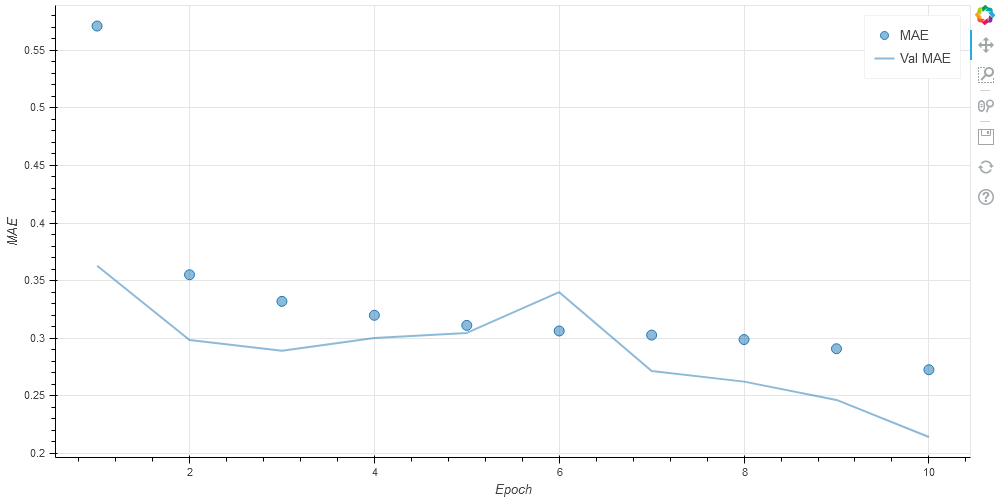

In [8]:
source = pd.DataFrame(history.history)
source['epoch'] = source.index + 1
acc_plot = figure(plot_width=1000, plot_height=500, x_axis_label='Epoch', y_axis_label='MAE')
acc_plot.circle(x='epoch', y='mean_absolute_error', source=source, size=10, fill_alpha=.5, legend_label='MAE')
acc_plot.line(x='epoch', y='val_mean_absolute_error', source=source, line_width=2, legend_label='Val MAE', alpha=0.5)
# show(acc_plot)
get_screenshot_as_png(acc_plot, driver=None)

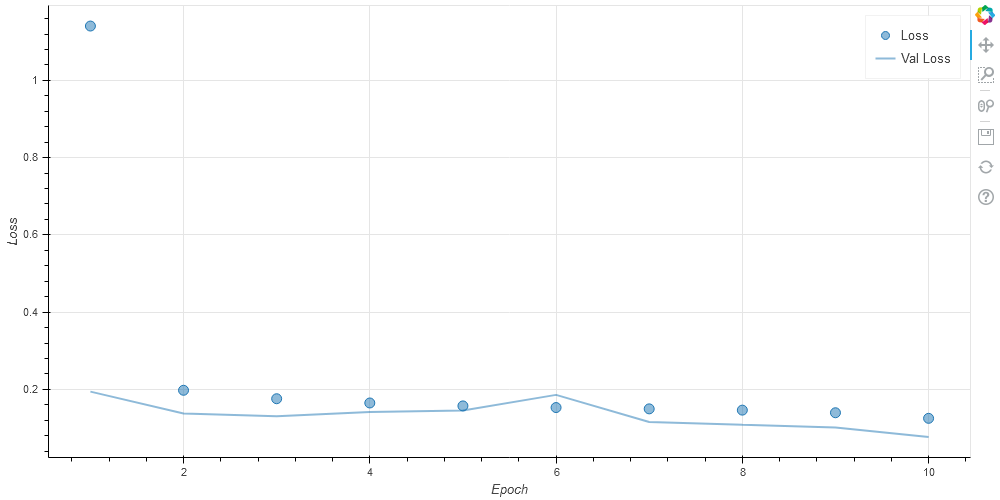

In [9]:
loss_plot = figure(plot_width=1000, plot_height=500, x_axis_label='Epoch', y_axis_label='Loss')
loss_plot.circle(x='epoch', y='loss', source=source, size=10, fill_alpha=.5, legend_label='Loss')
loss_plot.line(x='epoch', y='val_loss', source=source, line_width=2, legend_label='Val Loss', alpha=0.5)
# show(loss_plot)
get_screenshot_as_png(loss_plot, driver=None)

Previously achieved with NOAA weather data:  
  
Total prediction error: 113288.0  
Total ISOLF prediction error: 63146.0  
Percentage of time the model outperformed the NYISO model: 31.76 (175/551)  

In [10]:
predictions = model.predict(test.copy().drop(columns=['target']))
isolf = utils.isolf()
results = test.join(isolf, how='inner')
results['prediction'] = predictions
results['target'] *= std.target
results['target'] += mean.target
results['prediction'] *= std.target
results['prediction'] += mean.target
results['date'] = results.index
results = results.astype({'prediction': 'float'})

results, pred_plot = model_scoring.eval(results)

ValueError: Length of values does not match length of index

In [ ]:
# show(pred_plot)
get_screenshot_as_png(pred_plot, driver=None)

In [ ]:
results